In [1]:
import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi
import scipy.fftpack

import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
from PyHEADTAIL.particles.slicing import UniformBinSlicer
import PyHEADTAIL.particles.generators as generators
import PyHEADTAIL_feedback.processors as processors

np.random.seed(0)

PyHEADTAIL v1.9.4




In [2]:
class StepGenerator(object):
    def __init__(self,signal_function,t_window,frequency,points,amplitude,charge_spread):
        z_min = -1./(2.*frequency)*c
        z_max = (t_window-1./(2.*frequency))*c
        
        self.z_bins=np.linspace(z_min,z_max,points)
        self.mean_z = np.array([(i+j)/2. for i, j in zip(self.z_bins, self.z_bins[1:])])
        self.mean_x = amplitude*signal_function(self.mean_z*frequency/c)
        
        if charge_spread is not None:
            self.n_macroparticles_per_slice = 0.1*self.charge_dist(self.mean_z, charge_spread*c)

            for i, val in enumerate(self.n_macroparticles_per_slice):
                if val<1e-3:
                    self.n_macroparticles_per_slice[i]=0
        else:
            self.n_macroparticles_per_slice = np.ones(len(self.mean_z))
    
    def charge_dist(self, x, sig):
        return 1./(np.exp((-1.*x)/sig)+1.)
    
class SineStep(StepGenerator):
    def __init__(self,t_window,frequency,points,amplitude,charge_spread):
        super(self.__class__, self).__init__(self.signal_function,t_window,frequency,points,amplitude,charge_spread)
        
    def signal_function(self,x):
        signal=np.zeros(len(x))
        for i, val in enumerate(x):
            
            if val < 0:
                signal[i] = 0.
            else: 
                signal[i] = np.sin(val*2*pi)
        return signal
    
class ZeroStep(StepGenerator):
    def __init__(self,t_window,frequency,points,amplitude,charge_spread):
        super(self.__class__, self).__init__(self.signal_function,t_window,frequency,points,amplitude,charge_spread)
        
    def signal_function(self,x):
        signal=np.zeros(len(x))
        return signal

In [3]:
def pass_signal(signal_obj,processors):
    signal = signal_obj.mean_x
    for processor in processors:
        signal = processor.process(signal,signal_obj)
    signal_obj.mean_x = signal    
    return signal_obj

In [4]:
def calculate_RMS(signal_obj):
#     signal = np.array(signal_obj.mean_x)
    signal = signal_obj.mean_x
    return np.sqrt(np.mean(signal*signal))

In [5]:
def fft(signal_obj,N_signal,T_signal):
    signal = signal_obj.mean_x
    yf = scipy.fftpack.fft(signal)
    xf = np.linspace(0.0, 1.0/(2.0*T_signal), N_signal/2)

    return (xf, 2.0/N_signal * np.abs(yf[:N_signal/2]))

In [6]:
L_signal = 40
N_signal = 100*L_signal


f_c = 1e9
f_signal = 1.*f_c

# sample spacing
T_signal = L_signal*(1./f_signal) / float(N_signal)


orginal_signal =ZeroStep(L_signal*(1./f_signal),f_signal, N_signal,1.,None)

normal_distributed_noise = [
    processors.NoiseGenerator(1.0)
]
normal_distributed_signal = copy.deepcopy(orginal_signal)
normal_distributed_signal = pass_signal(normal_distributed_signal,normal_distributed_noise)

print calculate_RMS(normal_distributed_signal)


uniform_distributed_noise = [
    processors.NoiseGenerator(1.0, distribution = 'uniform')
]
uniform_distributed_signal = copy.deepcopy(orginal_signal)
uniform_distributed_signal = pass_signal(uniform_distributed_signal,uniform_distributed_noise)

print calculate_RMS(uniform_distributed_signal)


0.982255616266
1.00397856174


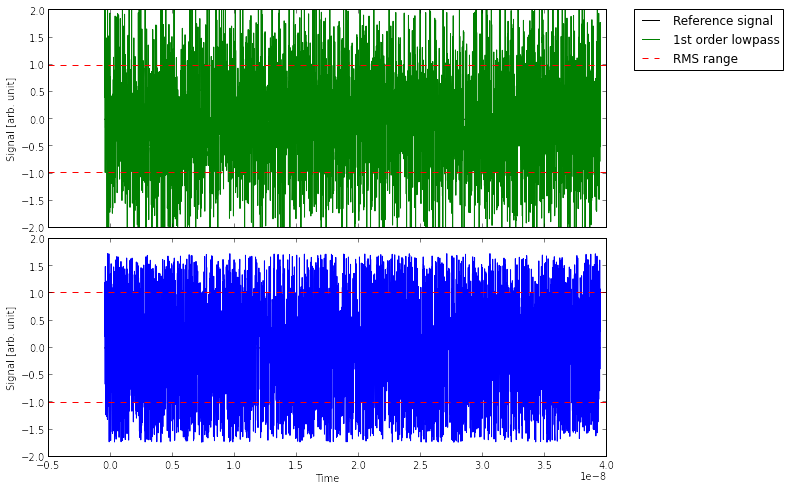

In [7]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)       
ax1.plot(orginal_signal.mean_z/c,orginal_signal.mean_x,'k-', label='Reference signal')
ax1.plot(orginal_signal.mean_z/c,normal_distributed_signal.mean_x,'g-', label='1st order lowpass')
ax1.set_xticklabels(())
ax1.title.set_visible(False)
ax1.set_ylabel('Signal [arb. unit]')
ax1.set_ylim([-2., 2.])
ax1.axhline(y=-1.*calculate_RMS(normal_distributed_signal),c="red", ls='--', label='RMS range')
ax1.axhline(y=1.*calculate_RMS(normal_distributed_signal),c="red", ls='--')
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax2 = fig.add_subplot(212)       
ax2.plot(orginal_signal.mean_z/c,orginal_signal.mean_x,'k-')
ax2.plot(orginal_signal.mean_z/c,uniform_distributed_signal.mean_x,'b-')
ax2.title.set_visible(False)
ax2.set_xlabel('Time')
ax2.set_ylabel('Signal [arb. unit]')
ax2.set_ylim([-2., 2.])
ax2.axhline(y=-1.*calculate_RMS(uniform_distributed_signal),c="red", ls='--', label='RMS range')
ax2.axhline(y=1.*calculate_RMS(uniform_distributed_signal),c="red", ls='--')
fig.subplots_adjust(hspace = .05)

In [8]:
filter_processors = [
    processors.LowpassFilter(f_c)
]
normal_distributed_filtered = copy.deepcopy(normal_distributed_signal)
normal_distributed_filtered = pass_signal(normal_distributed_filtered,filter_processors)
uniform_distributed_filtered = copy.deepcopy(uniform_distributed_signal)
uniform_distributed_filtered = pass_signal(uniform_distributed_filtered,filter_processors)

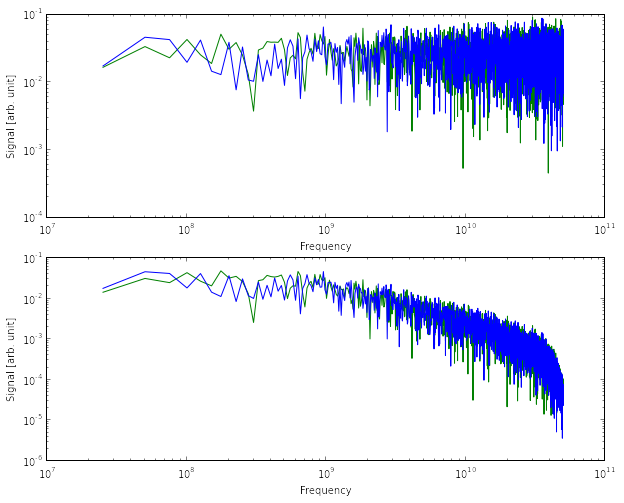

In [9]:
fft_normal = fft(normal_distributed_signal,N_signal,T_signal)
fft_uniform = fft(uniform_distributed_signal,N_signal,T_signal)
fft_normal_filtered = fft(normal_distributed_filtered,N_signal,T_signal)
fft_uniform_filtered = fft(uniform_distributed_filtered,N_signal,T_signal)

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax1.plot(fft_uniform[0],fft_uniform[1],'g-', label='Normal distribution')
ax1.plot(fft_normal[0],fft_normal[1],'b-', label='Uniform distribution')
ax1.set_ylabel('Signal [arb. unit]')
ax1.set_xlabel('Frequency')
ax1.set_yscale("log")
ax1.set_xscale("log")

ax2 = fig.add_subplot(212)
ax2.plot(fft_uniform[0],fft_uniform_filtered[1],'g-', label='Normal distribution')
ax2.plot(fft_normal[0],fft_normal_filtered[1],'b-', label='Uniform distribution')
ax2.set_ylabel('Signal [arb. unit]')
ax2.set_xlabel('Frequency')
ax2.set_yscale("log")
ax2.set_xscale("log")